**Подключаем нужные библиотеки**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread, imsave
from skimage.color import rgb2gray

**Начальное изображение**

In [2]:
img_numb = 1

(-0.5, 3455.5, 2303.5, -0.5)

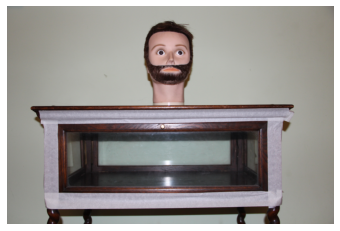

In [3]:
img = imread('data/IMG_' + str(img_numb) + '.jpg')
plt.imshow(img)
plt.axis('off')

## Определение контуров ящика

**Понижаем качество картинки**

(-0.5, 344.5, 229.5, -0.5)

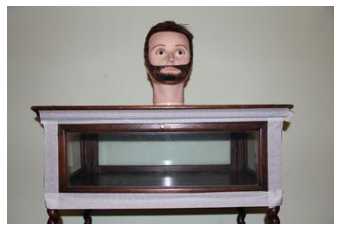

In [4]:
from PIL import Image

width = img.shape[1]//10
height = img.shape[0]//10
new_size = width, height

im = Image.open('data/IMG_' + str(img_numb) + '.jpg')
img_resized_pil = im.resize(new_size, Image.ANTIALIAS)
img_resized_pil.save('IMG_resized_tmp.jpg')

img_resized = imread('IMG_resized_tmp.jpg')
plt.imshow(img_resized)
plt.axis('off')

**Посмотрим, как работают разные фильтры**
Нужно было для определения наиболее оптимального фильтра. В итоге был взят фильтр Otsu

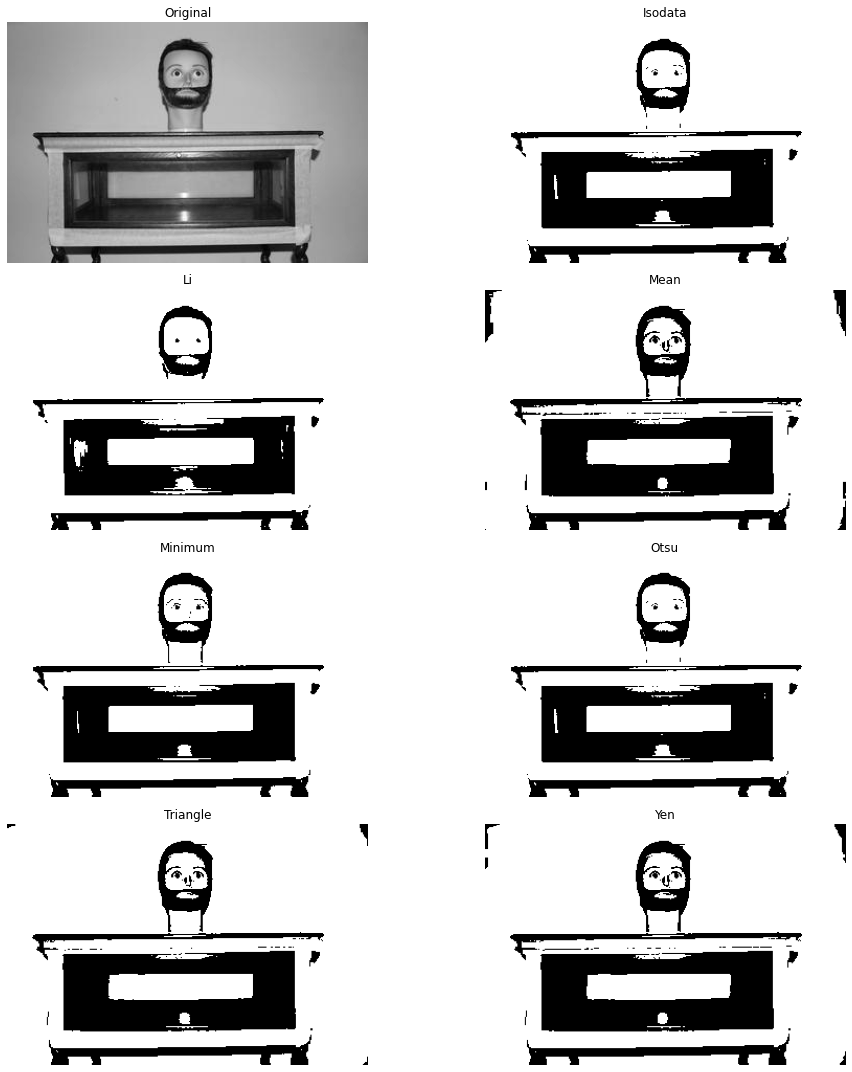

In [5]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(rgb2gray(img_resized), figsize=(15, 15), verbose=False)
plt.show()

**Бинаризуем изображение**

(-0.5, 344.5, 229.5, -0.5)

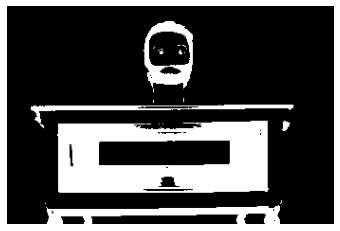

In [6]:
from skimage.filters import threshold_otsu

img_gray = rgb2gray(img_resized)
img_thresh = threshold_otsu(img_gray)
img_res_bin = img_gray <= img_thresh

plt.imshow(img_res_bin, cmap='gray')
plt.axis('off')

**Проведём анализ компонент связности на маске**

(-0.5, 344.5, 229.5, -0.5)

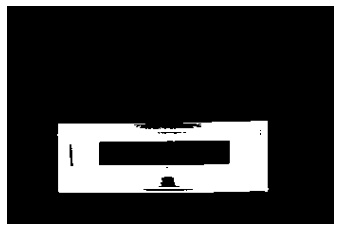

In [7]:
from skimage.measure import label, regionprops

def get_largest_component(mask):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

drawer = get_largest_component(img_res_bin)
plt.imshow(drawer, cmap='gray')
plt.axis('off')

**С помощью морфологических операций удаляем шумы**

(-0.5, 344.5, 229.5, -0.5)

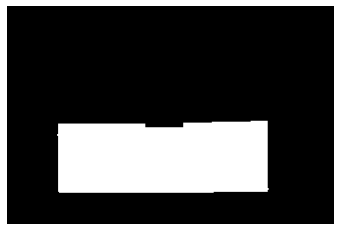

In [8]:
from skimage.morphology import binary_opening, binary_closing

drawer_enclosed = binary_closing(drawer, selem=np.ones((30, 30)))

plt.imshow(drawer_enclosed, cmap='gray')
plt.axis('off')

**С помощью преобразований Хафа находим верхнюю и нижнюю границу ящика**

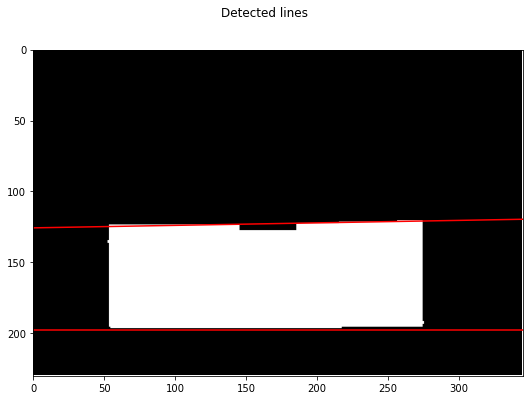

In [9]:
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from skimage.feature import canny

from matplotlib import cm

horiz_coords = list()

def hough_transform(image, name):
    h, theta, d = hough_line(canny(image))  # преобразование Хафа от границ изображения

    hough_fig = plt.figure(figsize=(15, 6))

    plt.imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        plt.plot((0, image.shape[1]), (y0, y1), '-r')
        horiz_coords.append((y0,y1)) # сохраняем координаты найденных линий

    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)

    hough_fig.savefig(name, bbox_inches='tight')

    plt.suptitle('Detected lines')

hough_transform(drawer_enclosed, 'IMG_drawer_hough_tmp.jpg')

**Находим высоту ящика по сохранённым координатам линий**

In [10]:
horiz_coords

[(197.73823884197827, 197.73823884197824),
 (125.67074192575211, 119.61509519154328)]

**Отфильтруем лишние прямые**. Оставим только две горизонтальные:самую верхнюю с самую нижнюю

In [11]:
horiz_coords_dict = dict()
horiz_coords_filtered = list()

for coord_id, coord in enumerate(horiz_coords):
    coord_middle = (coord[0] + coord[1])/2
    if abs(coord_middle) < drawer_enclosed.shape[0]:
        horiz_coords_dict[coord_middle] = coord

if len(horiz_coords_dict) > 0:
    min_key = min(horiz_coords_dict.keys())
    max_key = max(horiz_coords_dict.keys())

    horiz_coords_filtered.append(horiz_coords_dict[min_key])
    horiz_coords_filtered.append(horiz_coords_dict[max_key])

horiz_coords_filtered

[(125.67074192575211, 119.61509519154328),
 (197.73823884197827, 197.73823884197824)]

In [12]:
if len(horiz_coords_filtered) > 1:
    
    line_length = np.sqrt((horiz_coords_filtered[0][0] - 
                           horiz_coords_filtered[0][1])**2 + width**2) # находим длину одной из линий

    alpha = width / line_length # находим синус острого угла между вертикальной границей и одной из линий

    first_line_middle = (horiz_coords_filtered[0][0] + 
                         horiz_coords_filtered[0][1]) / 2 # находим y координаты центов обеих линий
    second_line_middle = (horiz_coords_filtered[1][0] + horiz_coords_filtered[1][1]) / 2

    drawer_height = abs(first_line_middle - second_line_middle) * alpha # находим расстояние между прямыми как высоту параллелограмма = боковой стенке * найденный синус угла
    print("Высота ящика = " + str(drawer_height))
else:
    drawer_height = 0

Высота ящика = 75.08375475668116


**Сохраняем результаты работы алгоритма**

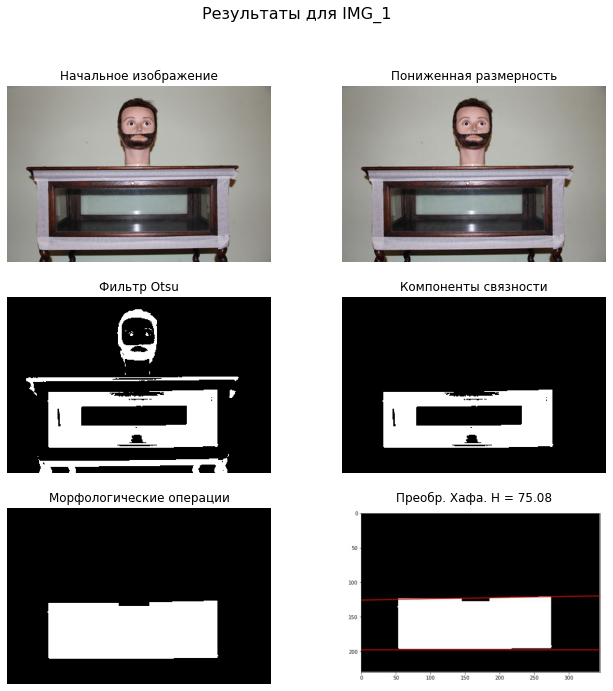

In [13]:
res_fig = plt.figure(figsize=(11, 11))

columns = 2
rows = 3

res_ax = []

hough_img = Image.open('IMG_drawer_hough_tmp.jpg')

plots = (img, img_resized, img_res_bin, drawer, drawer_enclosed, hough_img)
plots_names = ("Начальное изображение", "Пониженная размерность", "Фильтр Otsu", 
               "Компоненты связности", "Морфологические операции", "Преобр. Хафа. H = " + str(round(drawer_height, 2)))

for plt_ind in range(1, 7):
    res_ax.append(res_fig.add_subplot(rows, columns, plt_ind))
    res_ax[-1].set_title(plots_names[plt_ind-1])
    res_ax[-1].set_axis_off()
    plt.imshow(plots[plt_ind-1], cmap='gray')


res_fig.suptitle("Результаты для IMG_" + str(img_numb), fontsize=16)
plt.show()

res_fig.savefig('results/drawer/dr_res_img_' + str(img_numb) + '.jpg', bbox_inches='tight')

## Определение контуров объекта

**Обрежем изображение(с пониж. разрешением) снизу по верхней границе ящика**

(-0.5, 344.5, 122.5, -0.5)

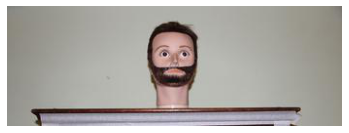

In [14]:
left = 0
right = width
top = 0
bottom = min(horiz_coords_dict.keys())

cropped_img_pil = img_resized_pil.crop((left, top, right, bottom))

cropped_img_pil.save('IMG_cropped_tmp.jpg')
cropped_img = imread('IMG_cropped_tmp.jpg')

plt.imshow(cropped_img)
plt.axis('off')


**Бинаризуем фильтром Yen**

(-0.5, 344.5, 122.5, -0.5)

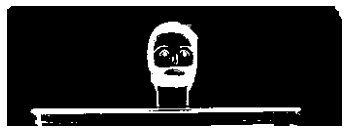

In [15]:
from skimage.filters import threshold_yen

cropped_img_gray = rgb2gray(cropped_img)
cropped_img_thresh = threshold_yen(cropped_img_gray)
cropped_img_res_bin = cropped_img_gray <= cropped_img_thresh

plt.imshow(cropped_img_res_bin, cmap='gray')
plt.axis('off')

**Проведём анализ компонент связности на маске**

(-0.5, 344.5, 122.5, -0.5)

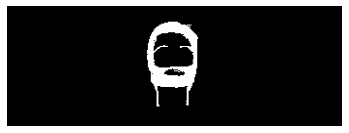

In [16]:
head = get_largest_component(cropped_img_res_bin)
plt.imshow(head, cmap='gray')
plt.axis('off')

**С помощью морфологических операций удаляем шумы**

(-0.5, 344.5, 122.5, -0.5)

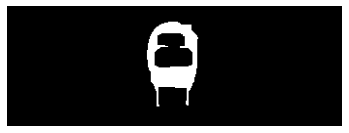

In [17]:
head_enclosed = binary_closing(head, selem=np.ones((10, 10)))

plt.imshow(head_enclosed, cmap='gray')
plt.axis('off')

**Найдём границы и размеры объекта**

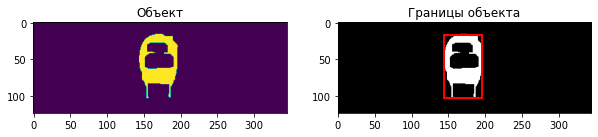

In [18]:
from matplotlib.patches import Rectangle

vertical_indices = np.where(np.any(head_enclosed, axis=1))[0]
top = vertical_indices[0]
bottom = vertical_indices[-1]

horizontal_indices = np.where(np.any(head_enclosed, axis=0))[0]
left = horizontal_indices[0]
right = horizontal_indices[-1]

border = Rectangle((left, top), right - left, bottom - top, linewidth=2, edgecolor='r', facecolor='none')

fig_b, ax_b = plt.subplots(1, 2, figsize=(10, 10))

ax_b[0].set_title('Объект')
ax_b[0].imshow(head_enclosed)

ax_b[1].set_title('Границы объекта')
ax_b[1].imshow(head_enclosed, cmap='gray')
ax_b[1].add_patch(border)

fig_b.savefig('IMG_boards_tmp.jpg', bbox_inches='tight')

## Подсчитаем, помещается ли объект в ящик

In [19]:
obj_height = abs(bottom-top)

print("Высота ящика = " + str(drawer_height))
print("Высота объекта = " + str(obj_height))

if obj_height > drawer_height:
    solution = "Объект не помещается в ящик"
else:
    solution = "Объект помещается в ящик"

print(solution)

Высота ящика = 75.08375475668116
Высота объекта = 86
Объект не помещается в ящик


## Найдем, на сколько нужно повернуть объект, чтобы он стал помещаться в ящик

In [20]:
import math

obj_width = abs(right-left)

coef_a = obj_height**2 + obj_width**2
coef_b = -2*drawer_height*obj_height
coef_c = drawer_height**2 - obj_width**2

discr = coef_b**2 - 4*coef_a*coef_c

if discr > 0:
    x1 = (-coef_b + math.sqrt(discr)) / (2 * coef_a)
    x2 = (-coef_b - math.sqrt(discr)) / (2 * coef_a)
    
    alpha_1 = math.acos(x1)*180/math.pi
    alpha_2 = math.acos(x2)*180/math.pi
    
    alpha = max(alpha_1, alpha_2)
    if alpha < 90:
        print("Угол поворота = %.2f°" % alpha)
    else:
        print("Объект не может пролезть в ящик")
elif discr == 0:
    x = -coef_b / (2 * coef_a)
    alpha = math.acos(x)*180/math.pi
    if alpha < 90:
        print("Угол поворота = %.2f°" % alpha)
    else:
        print("Объект не может пролезть в ящик")
else:
    print("Объект не может пролезть в ящик")
    

Угол поворота = 72.82°


**Сохраним результаты работы**(да-да, дупликация кода, будет что в код ревью написать)

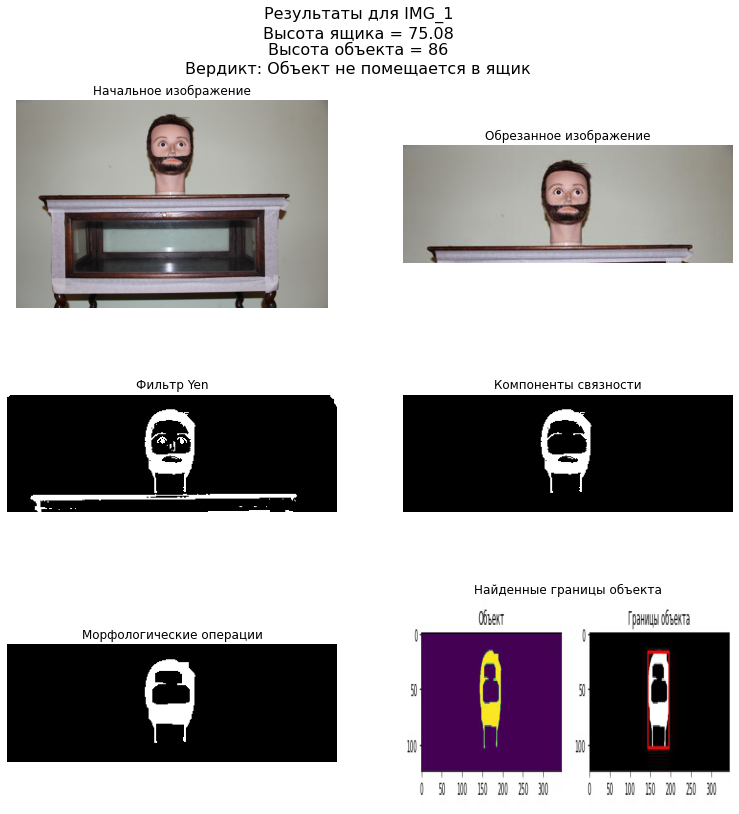

In [21]:
res_fig = plt.figure(figsize=(13, 13))

columns = 2
rows = 3

res_ax = []

board_img = Image.open('IMG_boards_tmp.jpg')

plots = (img, cropped_img, cropped_img_res_bin, head, head_enclosed, board_img)
plots_names = ("Начальное изображение", "Обрезанное изображение", "Фильтр Yen", 
               "Компоненты связности", "Морфологические операции", "Найденные границы объекта")

for plt_ind in range(1, 7):
    res_ax.append(res_fig.add_subplot(rows, columns, plt_ind))
    res_ax[-1].set_title(plots_names[plt_ind-1])
    res_ax[-1].set_axis_off()
    if plt_ind != 6:
        aspect_ = 'equal'
    else:
        aspect_ = 'auto'
    plt.imshow(plots[plt_ind-1], cmap='gray', aspect=aspect_)

res_fig.suptitle("Результаты для IMG_" + str(img_numb) + "\nВысота ящика = " + str(round(drawer_height, 2)) + 
                 "\nВысота объекта = " + str(round(obj_height, 2)) + 
                 "\nВердикт: " + solution, fontsize=16)
plt.show()

res_fig.savefig('results/object/obj_res_img_' + str(img_numb) + '.jpg', bbox_inches='tight')

### Комментарии
Пока что плохо работает задача определения головы на фотографии, зачастую остается кусок столешницы. Но в некоторых случаях все равно достаточно точно поределяет высотку головы.
А вот задача попорота пока что решается в редких случаях, так как ширина найденного объекта оказывается сильно больше настоящей

## Идеи по улучшению
1. **В поиске ящика можно обойтись без преобразований Хафа, судя по всему, проще просто находить границы по бинаризированному и отфильтрованому от шумов изображению, тогда еще и ширину можно будет найти**
2. **Визулизировать поворот объекта: добавить повернутую рамку между границами ящика, чтобы наглядно показать, что объект пролезает**
3. **Применить маску для более точного нахождения головы**